train function was executed
Loss: 1.0744013786315918
Loss: 9.21034049987793
Loss: 9.21034049987793
Loss: 13.815510749816895
Loss: 13.815510749816895
Loss: 4.605170249938965
Loss: 27.63102149963379
Loss: 13.815510749816895
Loss: 13.815510749816895
Loss: 13.815510749816895
Loss: 13.815510749816895
Loss: 13.815510749816895
Loss: 9.21034049987793
Loss: 18.42068099975586
Loss: 13.815510749816895
Loss: 9.21034049987793
Loss: 9.21034049987793
Loss: 13.815510749816895
Loss: 18.42068099975586
Loss: 9.21034049987793
Loss: 13.815510749816895
Loss: 9.21034049987793
Loss: 18.42068099975586
Loss: 9.21034049987793
Loss: 9.21034049987793
Loss: 18.42068099975586
Loss: 18.42068099975586
Loss: 13.815510749816895
Loss: 13.815510749816895
Loss: 13.815510749816895
Loss: 18.42068099975586
Loss: 13.815510749816895
Loss: 18.42068099975586
Loss: 13.815510749816895
Loss: 27.63102149963379
Loss: 4.605170249938965
Loss: 9.21034049987793
Loss: 13.815510749816895
Loss: 13.815510749816895
Loss: 13.815510749816895
Los

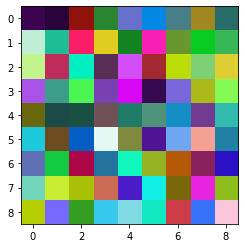

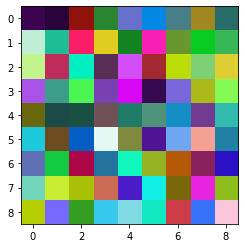

Likeliness value: tensor([1.], grad_fn=<SelectBackward>)
Loss: 4.605170249938965
Loss: 23.025850296020508
Loss: 18.42068099975586
Loss: 13.815510749816895
Loss: 13.815510749816895
Loss: 9.21034049987793
Loss: 13.815510749816895
Loss: 9.21034049987793
Loss: 9.21034049987793
Loss: 18.42068099975586
Loss: 9.21034049987793
Loss: 9.21034049987793
Loss: 23.025850296020508
Loss: 13.815510749816895
Loss: 13.815510749816895
Loss: 9.21034049987793
Loss: 0.0
Loss: 9.21034049987793
Loss: 9.21034049987793
Loss: 9.21034049987793
Loss: 23.025850296020508
Loss: 13.815510749816895
Loss: 4.605170249938965
Loss: 23.025850296020508
Loss: 23.025850296020508
Loss: 18.42068099975586
Loss: 18.42068099975586
Loss: 13.815510749816895
Loss: 18.42068099975586
Loss: 13.815510749816895
Loss: 23.025850296020508
Loss: 9.21034049987793
Loss: 9.21034049987793
Loss: 13.815510749816895
Loss: 9.21034049987793
Loss: 9.21034049987793
Loss: 4.605170249938965
Loss: 18.42068099975586
Loss: 9.21034049987793
Loss: 4.605170249938

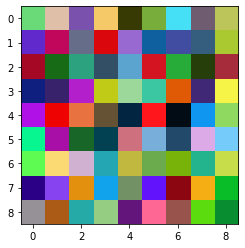

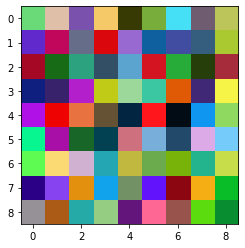

Likeliness value: tensor([1.], grad_fn=<SelectBackward>)
Loss: 18.42068099975586
Loss: 4.605170249938965
Loss: 9.21034049987793
Loss: 18.42068099975586
Loss: 9.21034049987793
Loss: 9.21034049987793
Loss: 13.815510749816895
Loss: 9.21034049987793
Loss: 23.025850296020508
Loss: 9.21034049987793
Loss: 18.42068099975586
Loss: 23.025850296020508
Loss: 18.42068099975586
Loss: 13.815510749816895
Loss: 13.815510749816895
Loss: 13.815510749816895
Loss: 13.815510749816895
Loss: 18.42068099975586
Loss: 9.21034049987793
Loss: 18.42068099975586
Loss: 18.42068099975586
Loss: 4.605170249938965
Loss: 13.815510749816895
Loss: 9.21034049987793
Loss: 23.025850296020508
Loss: 9.21034049987793
Loss: 4.605170249938965
Loss: 13.815510749816895
Loss: 9.21034049987793
Loss: 0.0
Loss: 18.42068099975586
Loss: 9.21034049987793
Loss: 18.42068099975586
Loss: 18.42068099975586
Loss: 13.815510749816895
Loss: 23.025850296020508
Loss: 13.815510749816895
Loss: 23.025850296020508
Loss: 18.42068099975586
Loss: 13.81551074

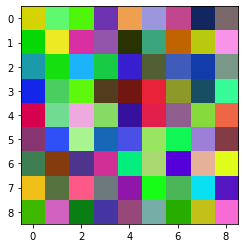

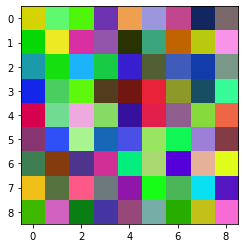

Likeliness value: tensor([1.], grad_fn=<SelectBackward>)
Loss: 13.815510749816895
Loss: 13.815510749816895
Loss: 0.0
Loss: 0.0
Loss: 9.21034049987793
Loss: 18.42068099975586
Loss: 9.21034049987793
Loss: 13.815510749816895
Loss: 4.605170249938965
Loss: 13.815510749816895
Loss: 18.42068099975586
Loss: 9.21034049987793
Loss: 23.025850296020508
Loss: 23.025850296020508
Loss: 23.025850296020508
Loss: 9.21034049987793
Loss: 9.21034049987793
Loss: 23.025850296020508
Loss: 18.42068099975586
Loss: 4.605170249938965
Loss: 13.815510749816895
Loss: 0.0
Loss: 4.605170249938965
Loss: 13.815510749816895
Loss: 18.42068099975586
Loss: 13.815510749816895
Loss: 18.42068099975586
Loss: 4.605170249938965
Loss: 23.025850296020508
Loss: 18.42068099975586
Loss: 18.42068099975586
Loss: 13.815510749816895
Loss: 9.21034049987793
Loss: 18.42068099975586
Loss: 9.21034049987793
Loss: 27.63102149963379
Loss: 23.025850296020508
Loss: 13.815510749816895
Loss: 23.025850296020508
Loss: 9.21034049987793
Loss: 4.605170249

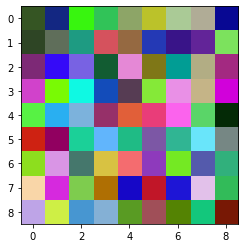

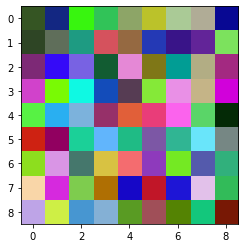

Likeliness value: tensor([1.], grad_fn=<SelectBackward>)
Loss: 18.42068099975586
Loss: 9.21034049987793
Loss: 13.815510749816895
Loss: 13.815510749816895
Loss: 18.42068099975586
Loss: 13.815510749816895
Loss: 4.605170249938965
Loss: 9.21034049987793
Loss: 13.815510749816895
Loss: 9.21034049987793
Loss: 13.815510749816895
Loss: 13.815510749816895
Loss: 9.21034049987793
Loss: 13.815510749816895
Loss: 18.42068099975586
Loss: 18.42068099975586
Loss: 13.815510749816895
Loss: 18.42068099975586
Loss: 18.42068099975586
Loss: 27.63102149963379
Loss: 9.21034049987793
Loss: 23.025850296020508
Loss: 9.21034049987793
Loss: 13.815510749816895
Loss: 18.42068099975586
Loss: 9.21034049987793
Loss: 9.21034049987793
Loss: 18.42068099975586
Loss: 13.815510749816895
Loss: 9.21034049987793
Loss: 13.815510749816895
Loss: 9.21034049987793
Loss: 18.42068099975586
Loss: 18.42068099975586
Loss: 9.21034049987793
Loss: 13.815510749816895
Loss: 13.815510749816895
Loss: 13.815510749816895
Loss: 13.815510749816895
Lo

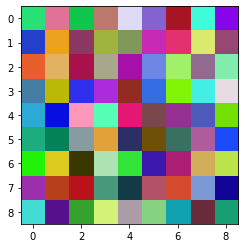

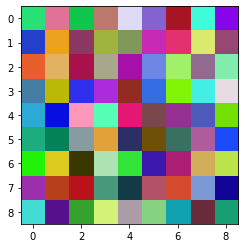

Likeliness value: tensor([1.], grad_fn=<SelectBackward>)
Loss: 18.42068099975586
Loss: 18.42068099975586
Loss: 23.025850296020508
Loss: 23.025850296020508
Loss: 13.815510749816895
Loss: 4.605170249938965
Loss: 13.815510749816895
Loss: 9.21034049987793
Loss: 13.815510749816895
Loss: 13.815510749816895
Loss: 13.815510749816895
Loss: 18.42068099975586
Loss: 18.42068099975586
Loss: 9.21034049987793
Loss: 9.21034049987793
Loss: 13.815510749816895
Loss: 13.815510749816895
Loss: 9.21034049987793
Loss: 9.21034049987793
Loss: 13.815510749816895
Loss: 23.025850296020508
Loss: 13.815510749816895
Loss: 13.815510749816895
Loss: 23.025850296020508
Loss: 18.42068099975586
Loss: 13.815510749816895
Loss: 18.42068099975586
Loss: 23.025850296020508
Loss: 9.21034049987793
Loss: 13.815510749816895
Loss: 18.42068099975586
Loss: 13.815510749816895
Loss: 9.21034049987793
Loss: 18.42068099975586
Loss: 9.21034049987793
Loss: 9.21034049987793
Loss: 13.815510749816895
Loss: 9.21034049987793
Loss: 18.4206809997558

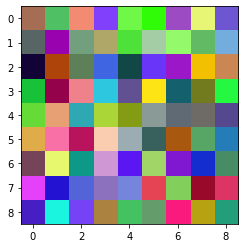

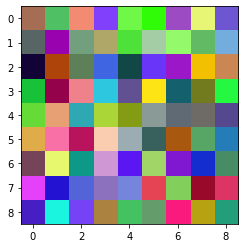

Likeliness value: tensor([1.], grad_fn=<SelectBackward>)
Loss: 9.21034049987793
Loss: 18.42068099975586
Loss: 9.21034049987793
Loss: 18.42068099975586
Loss: 13.815510749816895
Loss: 18.42068099975586
Loss: 13.815510749816895
Loss: 18.42068099975586
Loss: 9.21034049987793
Loss: 23.025850296020508
Loss: 18.42068099975586
Loss: 23.025850296020508
Loss: 9.21034049987793
Loss: 9.21034049987793
Loss: 18.42068099975586
Loss: 9.21034049987793
Loss: 13.815510749816895
Loss: 9.21034049987793
Loss: 23.025850296020508
Loss: 18.42068099975586
Loss: 13.815510749816895
Loss: 9.21034049987793
Loss: 23.025850296020508
Loss: 23.025850296020508
Loss: 13.815510749816895
Loss: 23.025850296020508
Loss: 9.21034049987793
Loss: 23.025850296020508
Loss: 13.815510749816895
Loss: 18.42068099975586
Loss: 9.21034049987793
Loss: 13.815510749816895
Loss: 18.42068099975586
Loss: 13.815510749816895
Loss: 4.605170249938965
Loss: 18.42068099975586
Loss: 23.025850296020508
Loss: 4.605170249938965
Loss: 9.21034049987793
Lo

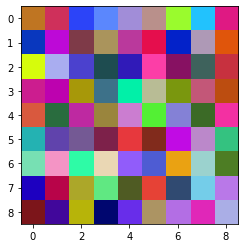

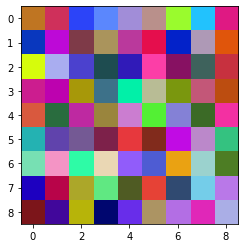

Likeliness value: tensor([1.], grad_fn=<SelectBackward>)
Loss: 13.815510749816895
Loss: 9.21034049987793
Loss: 4.605170249938965
Loss: 9.21034049987793
Loss: 9.21034049987793
Loss: 18.42068099975586
Loss: 13.815510749816895
Loss: 9.21034049987793
Loss: 23.025850296020508
Loss: 13.815510749816895
Loss: 13.815510749816895
Loss: 13.815510749816895
Loss: 18.42068099975586
Loss: 18.42068099975586
Loss: 9.21034049987793
Loss: 13.815510749816895
Loss: 9.21034049987793
Loss: 13.815510749816895
Loss: 13.815510749816895
Loss: 18.42068099975586
Loss: 18.42068099975586
Loss: 13.815510749816895
Loss: 13.815510749816895
Loss: 13.815510749816895
Loss: 13.815510749816895
Loss: 4.605170249938965
Loss: 13.815510749816895
Loss: 9.21034049987793
Loss: 13.815510749816895
Loss: 18.42068099975586
Loss: 4.605170249938965
Loss: 13.815510749816895
Loss: 18.42068099975586
Loss: 18.42068099975586
Loss: 13.815510749816895
Loss: 9.21034049987793
Loss: 13.815510749816895
Loss: 23.025850296020508
Loss: 18.42068099975

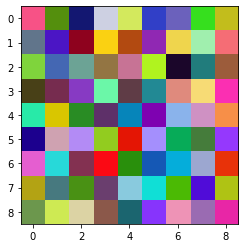

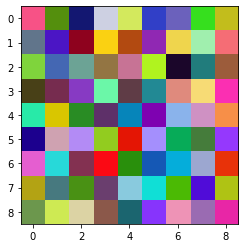

Likeliness value: tensor([1.], grad_fn=<SelectBackward>)
Loss: 13.815510749816895
Loss: 18.42068099975586
Loss: 18.42068099975586
Loss: 13.815510749816895
Loss: 23.025850296020508
Loss: 13.815510749816895
Loss: 23.025850296020508
Loss: 13.815510749816895
Loss: 9.21034049987793
Loss: 18.42068099975586
Loss: 18.42068099975586
Loss: 27.63102149963379
Loss: 9.21034049987793
Loss: 13.815510749816895
Loss: 9.21034049987793
Loss: 9.21034049987793
Loss: 18.42068099975586
Loss: 18.42068099975586
Loss: 4.605170249938965
Loss: 4.605170249938965
Loss: 23.025850296020508
Loss: 9.21034049987793
Loss: 18.42068099975586
Loss: 13.815510749816895
Loss: 18.42068099975586
Loss: 9.21034049987793
Loss: 9.21034049987793
Loss: 13.815510749816895
Loss: 13.815510749816895
Loss: 9.21034049987793
Loss: 18.42068099975586
Loss: 13.815510749816895
Loss: 13.815510749816895
Loss: 9.21034049987793
Loss: 23.025850296020508
Loss: 9.21034049987793
Loss: 9.21034049987793
Loss: 18.42068099975586
Loss: 0.0
Loss: 13.815510749

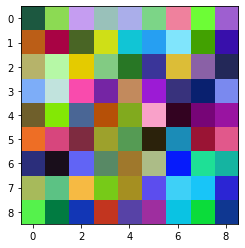

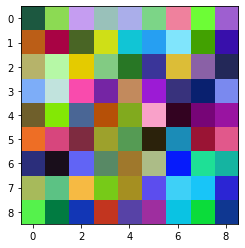

Likeliness value: tensor([1.], grad_fn=<SelectBackward>)
Loss: 18.42068099975586
Loss: 9.21034049987793
Loss: 18.42068099975586
Loss: 9.21034049987793
Loss: 23.025850296020508
Loss: 13.815510749816895
Loss: 9.21034049987793
Loss: 23.025850296020508
Loss: 4.605170249938965
Loss: 9.21034049987793
Loss: 13.815510749816895
Loss: 9.21034049987793
Loss: 13.815510749816895
Loss: 18.42068099975586
Loss: 18.42068099975586
Loss: 13.815510749816895
Loss: 9.21034049987793
Loss: 18.42068099975586
Loss: 9.21034049987793
Loss: 13.815510749816895
Loss: 13.815510749816895
Loss: 9.21034049987793
Loss: 13.815510749816895
Loss: 13.815510749816895
Loss: 18.42068099975586
Loss: 13.815510749816895
Loss: 13.815510749816895
Loss: 9.21034049987793
Loss: 23.025850296020508
Loss: 18.42068099975586
Loss: 18.42068099975586
Loss: 9.21034049987793
Loss: 13.815510749816895
Loss: 9.21034049987793
Loss: 13.815510749816895
Loss: 0.0
Loss: 4.605170249938965
Loss: 9.21034049987793
Loss: 4.605170249938965
Loss: 0.0
Loss: 27

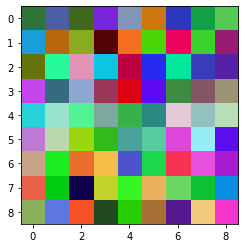

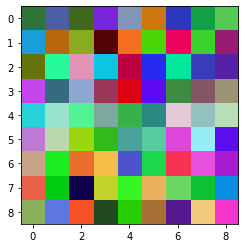

Likeliness value: tensor([1.], grad_fn=<SelectBackward>)
Loss: 4.605170249938965
Loss: 13.815510749816895
Loss: 13.815510749816895
Loss: 13.815510749816895
Loss: 13.815510749816895
Loss: 18.42068099975586
Loss: 13.815510749816895
Loss: 18.42068099975586
Loss: 18.42068099975586
Loss: 9.21034049987793
Loss: 4.605170249938965
Loss: 23.025850296020508
Loss: 9.21034049987793
Loss: 23.025850296020508
Loss: 9.21034049987793
Loss: 9.21034049987793
Loss: 13.815510749816895
Loss: 18.42068099975586
Loss: 18.42068099975586
Loss: 9.21034049987793
Loss: 9.21034049987793
Loss: 13.815510749816895
Loss: 13.815510749816895
Loss: 18.42068099975586
Loss: 18.42068099975586
Loss: 13.815510749816895
Loss: 13.815510749816895
Loss: 18.42068099975586
Loss: 18.42068099975586
Loss: 18.42068099975586
Loss: 13.815510749816895
Loss: 18.42068099975586
Loss: 13.815510749816895
Loss: 13.815510749816895
Loss: 13.815510749816895
Loss: 18.42068099975586
Loss: 18.42068099975586
Loss: 18.42068099975586
Loss: 13.815510749816

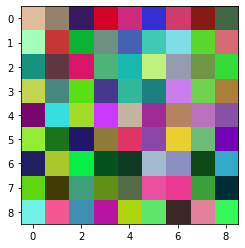

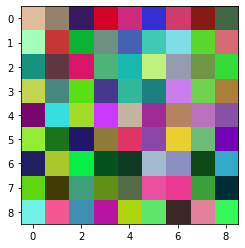

Likeliness value: tensor([1.], grad_fn=<SelectBackward>)
Loss: 9.21034049987793
Loss: 18.42068099975586
Loss: 13.815510749816895
Loss: 23.025850296020508
Loss: 9.21034049987793
Loss: 9.21034049987793
Loss: 27.63102149963379
Loss: 13.815510749816895
Loss: 13.815510749816895
Loss: 13.815510749816895
Loss: 23.025850296020508
Loss: 18.42068099975586
Loss: 18.42068099975586
Loss: 18.42068099975586
Loss: 13.815510749816895
Loss: 13.815510749816895
Loss: 9.21034049987793
Loss: 13.815510749816895
Loss: 13.815510749816895
Loss: 18.42068099975586
Loss: 18.42068099975586
Loss: 13.815510749816895
Loss: 9.21034049987793
Loss: 18.42068099975586
Loss: 9.21034049987793
Loss: 9.21034049987793
Loss: 4.605170249938965
Loss: 18.42068099975586
Loss: 13.815510749816895
Loss: 13.815510749816895
Loss: 0.0
Loss: 13.815510749816895
Loss: 13.815510749816895
Loss: 9.21034049987793
Loss: 13.815510749816895
Loss: 23.025850296020508
Loss: 13.815510749816895
Loss: 13.815510749816895
Loss: 18.42068099975586
Loss: 9.21

KeyboardInterrupt: ignored

In [0]:
import os
import torch
import torchvision
import torch.utils.data as utils
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset
from torch.autograd import Variable
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import timeit
import random

import matplotlib.pyplot as plt
import numpy as np

def imageBatch(nb_image):
    imgBatchR_T = torch.randint(0,255,(nb_image,3,9,9))
    imgBatchL_T = imgBatchR_T
    labelT = torch.ones(nb_image,1)

    imgBatchR_F = torch.randint(0,255,(nb_image,3,9,9)) #
    imgBatchL_F = torch.randint(0,255,(nb_image,3,9,9))
    labelF = torch.zeros(nb_image,1)

    finalR = torch.cat((imgBatchR_T,imgBatchR_F))
    finalL = torch.cat((imgBatchL_T,imgBatchL_F))
    finalLabel = torch.cat((labelT,labelF))

    return finalR, finalL, finalLabel

def firstStageCNN():
    return nn.Sequential(nn.Linear(3*9*9, 50), #L1
                         nn.ReLU(inplace=True),
                         
                         nn.Linear(50, 50), #L2
                         nn.ReLU(inplace=True))

class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()

        self.cnn1 = firstStageCNN()
        
        self.cnn2 = firstStageCNN()

        
        self.fc = nn.Sequential(nn.Linear(100, 75), #L3
                                nn.ReLU(inplace=True),
                                
                                nn.Linear(75, 50), #L4
                                nn.ReLU(inplace=True),
                            
                                nn.Linear(50, 25), #L5
                                nn.ReLU(inplace=True),
                                
                                nn.Linear(25, 1), #L6
                                nn.Sigmoid())
    
    def forward(self, input1, input2):
        
        output1 = self.cnn1(input1.float().view(-1,3*9*9))
        output2 = self.cnn2(input2.float().view(-1,3*9*9))


        combined = torch.cat((output1.view(output1.size(0), -1),
                              output2.view(output2.size(0), -1)), dim=1)

        combined = torch.unsqueeze(combined,2)
        combined = torch.unsqueeze(combined,3)
        combined = combined.view(-1,100)
        
        out = self.fc(combined)
        
        return out

def train(net, finalR, finalL, finalLabel, EPOCHS, BATCH_SIZE):
    height, width = 9,9
    optimizer = optim.Adam(net.parameters(), lr=0.05)
    loss_function = nn.BCELoss()
    dataset = utils.TensorDataset(finalL, finalR, finalLabel)
    train_dataloader = DataLoader(dataset, shuffle=True, num_workers=8, batch_size=6)
    COUNTER = 1
    net.zero_grad()

    print("train function was executed")
    for epoch in range(EPOCHS):
        avg_loss = 0
        for i, data in enumerate(train_dataloader):
            img1, img2, depthmap = data
            # img1, img2, depthmap = img1.cuda(), img2.cuda(), depthmap.cuda()
            optimizer.zero_grad() # reset gradient
            outputs = net(img1, img2)
            outputs = outputs.cpu()
            depthmap = depthmap.cpu()
            loss = loss_function(outputs, depthmap)
            print("Loss:", float(loss))
            avg_loss+=loss
            loss.backward()
            optimizer.step()
        #Print out images and epoch numbers 
        print("Epoch number: ", COUNTER)
        COUNTER += 1 
        # avg_loss = np.array(avg_loss)
        print("Average Loss:", avg_loss/i)
        # plot_weights(net.cpu(), 0, single_channel = False)
        outputs = outputs.cpu()
        img1 = img1.cpu()
        img2 = img2.cpu()
        depthmap = depthmap.cpu()
        print("Output size", outputs.size())
        for param in net.parameters():
            print('average weight per layer: ', np.mean(np.array(param.data.cpu())))
        image = img1[0].view(3,height,width)
        image = img2[0].view(3,height,width)
        plt.figure()
        plt.imshow(np.swapaxes(np.swapaxes(image.detach().numpy(),0,2),0,1))
        plt.figure()
        plt.imshow(np.swapaxes(np.swapaxes(image.detach().numpy(),0,2),0,1))
        plt.show()
        print('Likeliness value:', outputs[-1])
    return net

def main():
  net = SiameseNetwork()
  net#.cuda()
  NumberIMG = 500
  EPOCHS = 50

  finalR, finalL, finalLabel = imageBatch(NumberIMG)

  final = train(net,finalR, finalL, finalLabel,EPOCHS,NumberIMG)

if __name__ == '__main__':
    main()